# Title and Introduction
# Exploratory Data Analysis and Preprocessing for CFPB Complaint Dataset

This notebook performs **Task 1** of the project: Exploratory Data Analysis (EDA) and preprocessing of the Consumer Financial Protection Bureau (CFPB) complaint dataset (~5.64GB).

## Objectives
- Understand the structure, volume, and language content of the dataset.
- Identify issues related to data quality (missing values, noise, duplicates).
- Explore product distribution and consumer complaint characteristics.
- Prepare a cleaned and filtered dataset for downstream use in a RAG-powered chatbot.

---


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from google.colab import drive
from collections import Counter

%matplotlib inline
sns.set_style('whitegrid')

# Mount Google Drive and Set Paths

In [5]:
drive.mount('/content/drive')

DATA_DIR = Path("/content/drive/MyDrive/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)
dataset_path = DATA_DIR / "complaints.csv"
CHUNK_SIZE = 100_000

Mounted at /content/drive


#Load and Aggregate Data (in Chunks to Handle Memory)



In [7]:
total_rows = 0
product_counts = pd.Series(dtype=int)
missing_narratives = 0
narrative_lengths = []
chunks = []
all_issues = Counter()
all_sub_issues = Counter()
all_submission_methods = Counter()

for chunk in pd.read_csv(dataset_path, chunksize=CHUNK_SIZE, low_memory=False):
    total_rows += len(chunk)
    product_counts = product_counts.add(chunk['Product'].value_counts(), fill_value=0)
    missing_narratives += chunk['Consumer complaint narrative'].isnull().sum()
    chunk['narrative_length'] = chunk['Consumer complaint narrative'].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    narrative_lengths.extend(chunk['narrative_length'].tolist())
    all_issues.update(chunk['Issue'].dropna().astype(str))
    all_sub_issues.update(chunk['Sub-issue'].dropna().astype(str))
    all_submission_methods.update(chunk['Submitted via'].dropna().astype(str))
    chunks.append(chunk)

print(f"Total Rows: {total_rows}")
print(f"Total Missing Narratives: {missing_narratives}")

Total Rows: 9609797
Total Missing Narratives: 6629041


# --------------------------------------
# EDA Visualizations
# --------------------------------------

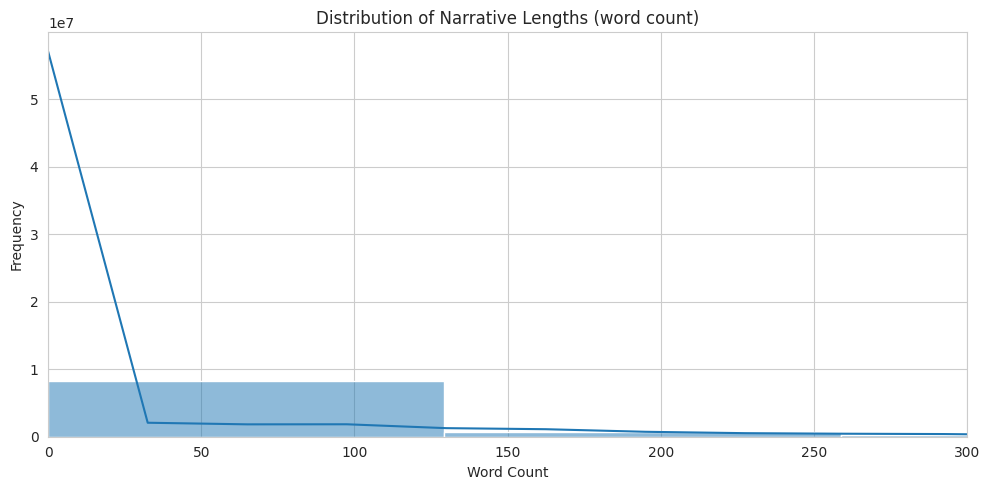

In [13]:
# Narrative length distribution
narrative_lengths = pd.Series(narrative_lengths)
plt.figure(figsize=(10, 5))
sns.histplot(narrative_lengths, bins=50, kde=True)
plt.title("Distribution of Narrative Lengths (word count)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.xlim(0, 300)
plt.tight_layout()
plt.show()

# Product Category Overview

In [9]:
product_list = set()
for chunk in chunks:
    product_list.update(chunk['Product'].dropna().unique())
print("Unique Product Categories:\n", sorted(product_list))

Unique Product Categories:
 ['Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Credit card', 'Credit card or prepaid card', 'Credit reporting', 'Credit reporting or other personal consumer reports', 'Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Debt or credit management', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Mortgage', 'Other financial service', 'Payday loan', 'Payday loan, title loan, or personal loan', 'Payday loan, title loan, personal loan, or advance loan', 'Prepaid card', 'Student loan', 'Vehicle loan or lease', 'Virtual currency']


# Very Short Narratives (QA Check)

In [14]:
short_samples = []
for chunk in chunks:
    short = chunk[chunk['Consumer complaint narrative'].str.split().str.len() < 10]
    short_samples.extend(short['Consumer complaint narrative'].dropna().tolist())
    if len(short_samples) > 10:
        break
print("Sample of Short Narratives (<10 words):\n")
for s in short_samples[:10]:
    print("-", s)

Sample of Short Narratives (<10 words):

- The following accounts are not mine and were unauthorized
- Credit report showing delinquency when it is not accurate.
- Hard inquiries that is not connected to a account
- My personal and financial data was compromised violating FERPA..
- Request validation of debt and did not receive it.
- I saiid XXXX XXXX never open XXXX account
- The reported late payments are incorrect, incomplete, or unverifiable
- I received a text message regarding a non-existent account:
- Filed complain via cfpb. Response was not sufficient.
- The reported late payments are incorrect, incomplete, or unverifiable


# Random Narrative Samples for Qualitative Review

In [15]:
import random
sample_texts = []
for chunk in chunks:
    sample_texts.extend(chunk['Consumer complaint narrative'].dropna().sample(3, random_state=42).tolist())
    if len(sample_texts) > 9:
        break
print("Random Complaint Narrative Samples:\n")
for i, text in enumerate(sample_texts[:9]):
    print(f"{i+1}.", text[:300], "...\n")

Random Complaint Narrative Samples:

1. I made on XX/XX/year> {$920.00} payment to my credit card payment from my credit union account. There was a glitch with my credit union that caused the payment to be returned. 

I called Barclay 's and they advised me to get a letter from my credit union and they would refund the return payment fee. ...

2. Credit Collections obtained access to my consumer credit report without my knowledge, authorization, or a permissible purpose, as required by the Fair Credit Reporting Act ( FCRA ), specifically 15 U.S.C. 1681b ( b ) ( 2 ). 

I was not provided with a clear and conspicuous written disclosure prior t ...

3. I have not supplied proof under the doctrine of estoppel by silence, Engelhardt V. Gravens ( MO ) XXXX XXXX XXXX. I pressume that no proof of the alleged debt, nor therefore any such debt, in fact therefore exist. ...

4. XXXX reaching out for your help regarding the incorrect account listed on my credit report. This situation has damaged m

# --------------------------------------
# Filtering & Preprocessing
# --------------------------------------

In [23]:
PRODUCT_MAPPING = {
    "Credit card": "Credit Cards",
    "Credit card or prepaid card": "Credit Cards",
    "Prepaid card": "Credit Cards",
    "Personal loan": "Personal Loans",
    "Payday loan, title loan, or personal loan": "Personal Loans",
    "Payday loan, title loan, personal loan, or advance loan": "Personal Loans",
    "Consumer Loan": "Personal Loans",
    "Buy Now, Pay Later (BNPL)": "Buy Now, Pay Later (BNPL)",
    "Savings account": "Savings Accounts",
    "Checking or savings account": "Savings Accounts",
    "Money transfers": "Money Transfers",
    "Money transfer, virtual currency, or money service": "Money Transfers"
}

KEYWORDS = ['fraud', 'charge', 'bill', 'unauthorized', 'loan', 'transfer', 'card', 'credit', 'debt', 'dispute']

def clean_narrative(text):
    if pd.isnull(text):
        return None
    text = text.lower()
    text = re.sub(r'{.*?}', '', text)
    text = re.sub(r'xxxx+', '', text)
    text = re.sub(r'[^a-z0-9\s.,!?$]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    boilerplate_phrases = [
        r"i am writing to file a complaint", r"please assist me",
        r"this is regarding my account", r"thank you for your time",
        r"to whom it may concern"
    ]
    for phrase in boilerplate_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)

    if len(text.split()) < 10 and not any(keyword in text for keyword in KEYWORDS):
        return None
    return text

filtered_chunks = []
filtered_count = 0
deduped_count = 0
for chunk in chunks:
    chunk = chunk.copy()
    chunk['ProductCategory'] = chunk['Product'].map(PRODUCT_MAPPING)
    chunk = chunk[chunk['ProductCategory'].notnull()]
    chunk = chunk[chunk['Consumer complaint narrative'].notnull()]
    chunk['cleaned_narrative'] = chunk['Consumer complaint narrative'].apply(clean_narrative)
    chunk = chunk[chunk['cleaned_narrative'].notnull()]
    filtered_chunks.append(chunk)
    filtered_count += len(chunk)

filtered_df = pd.concat(filtered_chunks)

# Global deduplication by Complaint ID
before_dedup = len(filtered_df)
filtered_df = filtered_df.drop_duplicates(subset='Complaint ID')
after_dedup = len(filtered_df)
deduped_count = before_dedup - after_dedup
print(f"Removed {before_dedup - after_dedup} duplicate complaints.")

Removed 0 duplicate complaints.


# --------------------------------------
# Final Column Selection
# --------------------------------------

In [43]:
rag_columns = [
    'Complaint ID',
    'ProductCategory',
    'Issue',
    'Company',
    'Date received',
    'cleaned_narrative'
]
filtered_df = filtered_df[rag_columns].copy()

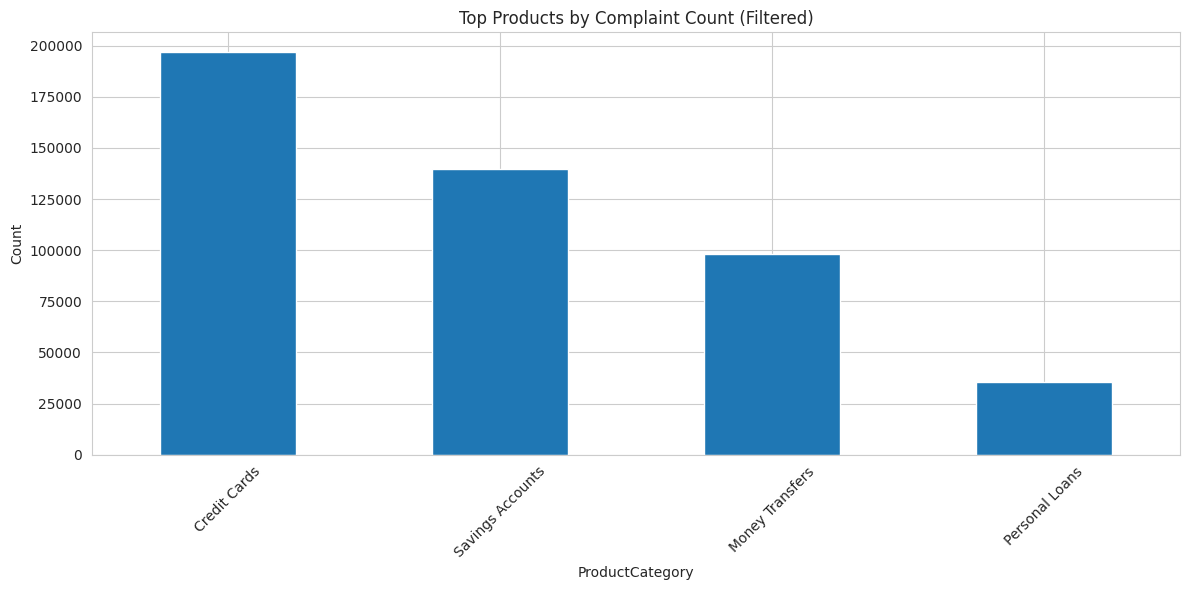

In [44]:
plt.figure(figsize=(12, 6))
filtered_df['ProductCategory'].value_counts().head(15).plot(kind='bar')
plt.title("Top Products by Complaint Count (Filtered)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

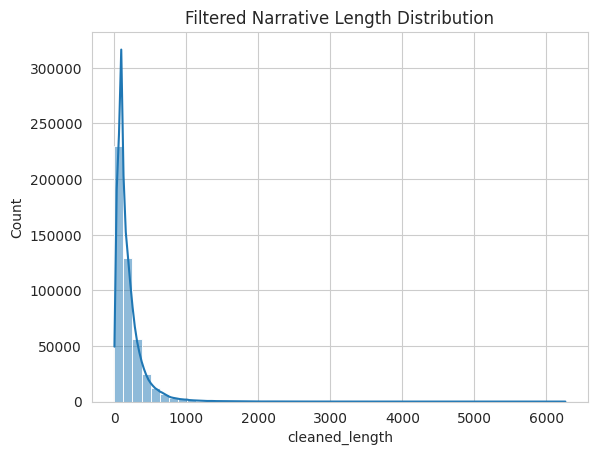

In [45]:
filtered_df['cleaned_length'] = filtered_df['cleaned_narrative'].apply(lambda x: len(x.split()))
sns.histplot(filtered_df['cleaned_length'], bins=50, kde=True)
plt.title("Filtered Narrative Length Distribution")
plt.show()

# --------------------------------------
# Save Cleaned Dataset
# --------------------------------------

In [46]:
OUTPUT = Path("/content/drive/MyDrive/filter")
OUTPUT.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH = OUTPUT / "filtered_complaints.csv"
filtered_df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved cleaned dataset with {len(filtered_df)} rows to {OUTPUT_PATH}")

Saved cleaned dataset with 470118 rows to /content/drive/MyDrive/filter/filtered_complaints.csv


In [47]:
from IPython.display import display, Markdown

def md(text):
    display(Markdown(text))

md(f"""
## Summary: Exploratory Data Analysis and Preprocessing

**Business Questions Answered:**
- The dataset contains **{total_rows:,}** total complaints.
- Approximately **{missing_narratives:,}** narratives (or {missing_narratives/total_rows:.2%}) were missing.
- The most common product with complaints was **{product_counts.idxmax()}**.

**Data Quality Actions Taken:**
- Rows missing complaint narratives were dropped.
- Narratives under 10 words were dropped unless they included critical keywords.
- Duplicate Complaint IDs were dropped — {deduped_count} removed.

**Filtered Dataset Characteristics:**
- Total rows after filtering: **{len(filtered_df):,}**
- Columns retained: Complaint ID, ProductCategory, Issue, Company, Date received, cleaned_narrative
- Cleaned data saved at: `{OUTPUT_PATH}`

**Next Step →** Proceed to Task 2: Chunking and Semantic Embedding.
""")


## Summary: Exploratory Data Analysis and Preprocessing

**Business Questions Answered:**
- The dataset contains **9,609,797** total complaints.
- Approximately **6,629,041** narratives (or 68.98%) were missing.
- The most common product with complaints was **Credit reporting or other personal consumer reports**.

**Data Quality Actions Taken:**
- Rows missing complaint narratives were dropped.
- Narratives under 10 words were dropped unless they included critical keywords.
- Duplicate Complaint IDs were dropped — 0 removed.

**Filtered Dataset Characteristics:**
- Total rows after filtering: **470,118**
- Columns retained: Complaint ID, ProductCategory, Issue, Company, Date received, cleaned_narrative
- Cleaned data saved at: `/content/drive/MyDrive/filter/filtered_complaints.csv`

**Next Step →** Proceed to Task 2: Chunking and Semantic Embedding.
